### Cab-Driver Agent

**Note:**<br>
(i) Considering **Architecture 2** given in the problem statement **(where Input: State only)**.<br>
(ii) The corresponding function returning an encoded state is a vector of size "m+t+d" (wnere m:no. of locations/cities, t:hours, d:days_of_week). It is named as **'state_encod_arch2'** in the Env.py file and shall be used further in this code.

## Architecture 2  (where Input: State only)
![Arch2_Image](Architecture_2_Image(Input_State_Only).PNG)

In [1]:
# Importing libraries
import sys
import numpy as np
np.set_printoptions(threshold=sys.maxsize)  
import pandas as pd
import random
import time
import math
from collections import deque
import collections
import pickle

# for building DQN model
from tensorflow import keras
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam


# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import *    

# Suppress Warnings
import warnings
warnings.filterwarnings("ignore")

# Suppress Tensorflow Warnings 
import tensorflow as tf
#tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)  

Using TensorFlow backend.


#### Defining Time Matrix

In [2]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

In [3]:
print(Time_matrix.shape)
print(Time_matrix[3][4][17][5]) #Example: (Returns Time Taken) 𝑇𝑖𝑚𝑒−𝑚𝑎𝑡𝑟𝑖𝑥[𝑠𝑡𝑎𝑟𝑡−𝑙𝑜𝑐][𝑒𝑛𝑑−𝑙𝑜𝑐][ℎ𝑜𝑢𝑟−𝑜𝑓−𝑡ℎ𝑒−𝑑𝑎𝑦] [𝑑𝑎𝑦−𝑜𝑓−𝑡ℎ𝑒−𝑤𝑒𝑒𝑘]

(5, 5, 24, 7)
6.0


For<br>𝑠𝑡𝑎𝑟𝑡−𝑙𝑜𝑐: **3**<br>𝑒𝑛𝑑−𝑙𝑜𝑐: **4**<br>ℎ𝑜𝑢𝑟−𝑜𝑓−𝑡ℎ𝑒−𝑑𝑎𝑦: **17**<br>𝑑𝑎𝑦−𝑜𝑓−𝑡ℎ𝑒−𝑤𝑒𝑒𝑘: **5**<br>The time taken by the cab driver is **6.0 hours**.        

In [4]:
## Understanding the min and max time duration of trips from one point to another

print("Minimimum time taken:", Time_matrix.min())
print("Maximum time taken:", Time_matrix.max())
print("Average time taken:", Time_matrix.mean())

Minimimum time taken: 0.0
Maximum time taken: 11.0
Average time taken: 3.0542857142857143


The maximum time taken is 11 hours. So, it is safe to say that the maximum time taken by the cab driver to move from one point to another is less than 1 day.

In [5]:
## Check Random State
from Env import CabDriver 
print("Random State Initialization:")
for i in range(5):         ## Checking for 5 epsiodes
    env= CabDriver()
    random_state_init= env.state_init
    print(random_state_init)

Random State Initialization:
(1, 23, 3)
(1, 13, 0)
(4, 14, 3)
(4, 7, 3)
(2, 13, 2)


In [6]:
## Creating tuples of action_index and actions from action_space
from Env import CabDriver
env= CabDriver()
cab_action_space = env.action_space
cab_action_indices =[i for i in range(len(cab_action_space))]
action_list= [i for i in zip(cab_action_indices, cab_action_space)]   ## tuples (action_indices, action)
print("Action List (action_indices, action):")
action_list

Action List (action_indices, action):


[(0, (0, 0)),
 (1, (0, 1)),
 (2, (0, 2)),
 (3, (0, 3)),
 (4, (0, 4)),
 (5, (1, 0)),
 (6, (1, 2)),
 (7, (1, 3)),
 (8, (1, 4)),
 (9, (2, 0)),
 (10, (2, 1)),
 (11, (2, 3)),
 (12, (2, 4)),
 (13, (3, 0)),
 (14, (3, 1)),
 (15, (3, 2)),
 (16, (3, 4)),
 (17, (4, 0)),
 (18, (4, 1)),
 (19, (4, 2)),
 (20, (4, 3))]

In [7]:
## Understanding state_size
state_size= m+t+d               ## Considering DQN_Architecture 2 (Input: State Only)
print("state_size:", state_size)

state_size: 36


In [8]:
## Understanding action_size
action_size= len(env.action_space)
print("action_size:",action_size)

action_size: 21


### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [9]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.95
        self.learning_rate =  0.01   
        self.epsilon = 1
        self.epsilon_max = 1
        self.epsilon_decay = -0.00045
        self.epsilon_min = 0.0000001
        
        self.batch_size = 32        
        # Create replay memory using deque
        self.memory = deque(maxlen=2000)
        
        # Initialize the value of the states tracked for all samples
        self.states_tracked_1 = []
        self.states_tracked_2 = []
        
        
        # For Sample state-action pair 1: We are going to track state (2,4,6) and action (2,3) at index 11 in the action space.
        self.track_state_1 = np.array(env.state_encod_arch2((2,4,6))).reshape(1, self.state_size)
        
        # For Sample state-action pair 2: We are going to track state (1,2,3) and action (1,2) at index 6 in the action space.
        self.track_state_2 = np.array(env.state_encod_arch2((1,2,3))).reshape(1, self.state_size)
        

        # Create main model and target model
        self.model = self.build_model()

    # approximate Q function using Neural Network
    def build_model(self):
        """
        Takes in the agent and constructs a neural network to train it and returns model and parameters.
        """
        model = Sequential()
        # Write your code here: Add layers to your neural nets 
        
        # Hidden Layers 
        model.add(Dense(32, input_dim= self.state_size, activation= 'relu', kernel_initializer= 'he_uniform'))
        model.add(Dense(32, activation= 'relu', kernel_initializer= 'he_uniform'))
        
        # the output layer: output is of size of number of actions (action_size) and returns Q values for all actions
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))
        
        # Compile Model
        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
        model.summary
        
        return model



    def get_action(self, state):
        
    # Write your code here:
    # get action from model using epsilon-greedy policy
    # Decay in ε after we generate each sample from the environment   
    
        # Get a list of the ride requests driver got.
        possible_actions_index, actions= env.requests(state)
        
        # get action from model using epsilon-greedy policy
        z = np.random.random()  ## variable z randomly chooses a value between [0,1)
        if z <= self.epsilon:
            # explore: choose a random action from all possible actions
            return random.randrange(self.action_size)
        else:
            # choose the action with the highest q(s, a)
            # the first index corresponds to the batch size, so
            # reshape state to (1, state_size) so that the first index corresponds to the batch size
            state = np.array(env.state_encod_arch2(state)).reshape(1, self.state_size)
            
            # Use the model to predict the Q_values.
            q_vals = self.model.predict(state)
            
            # Truncate the array to only those actions that are part of the ride  requests.
            q_vals_possible = np.array([q_vals[0][i] for i in possible_actions_index])

            return possible_actions_index[np.argmax(q_vals_possible)]

        
    def append_sample(self, state, action_index, reward, next_state, done):
        """appends the new agent run output to replay buffer"""
    # Write your code here:
    # save sample <s,a,r,s'> to the replay memory. Also, taking argument 'done' --> terminal state flag.
        self.memory.append((state, action_index, reward, next_state, done))
    

    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        """ 
        Function to train the model on each step run.
        Picks the random memory events according to batch size and 
        runs it through the network to train it.
        """
        # Write your code from here
        # 1. Update your 'update_output' and 'update_input' batch           
        # 2. Predict the target from earlier model
        # 3. Get the target for the Q-network
        
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            # initialise two matrices - update_input and update_output
            update_input = np.zeros((self.batch_size, self.state_size))
            update_output = np.zeros((self.batch_size, self.state_size))
            actions, rewards, done = [], [], []
            
             # Update your 'update_output' and 'update_input' batch
            # populate update_input and update_output and the lists rewards, actions, done
            for i in range(self.batch_size):
                state, action, reward, next_state, done_boolean = mini_batch[i]
                update_input[i] = env.state_encod_arch2(state)     
                actions.append(action)
                rewards.append(reward)
                update_output[i] = env.state_encod_arch2(next_state)
                done.append(done_boolean)

            # predict the target q-values from states s
            target = self.model.predict(update_input)
            # target for q-network
            target_qval = self.model.predict(update_output)


            # update the target values
            for i in range(self.batch_size):
                if done[i]:      #terminal state
                    target[i][actions[i]] = rewards[i]
                else:            # non-terminal state
                    target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(target_qval[i])
             # 4. Fit your model and track the loss values
            # model fit
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)
    
    def save_tracking_states(self):
        # Use the model to predict the q_value of the state we are tacking.
        q_value_1 = self.model.predict(self.track_state_1)
        q_value_2 = self.model.predict(self.track_state_2)

        
        # Grab the q_value of the action index that we are tracking.
        self.states_tracked_1.append(q_value_1[0][11])    ## action (2,3) at index 11 in the action space
        self.states_tracked_2.append(q_value_2[0][6])     ## action (1,2) at index 6 in the action space

        
    def save_weights_numpy(self, name):      ## Saves the 'model_weights' in a  pickle file
        weights= self.model.get_weights()   ## Gets model_weights as a list of numpy arrays
        try:
            fpkl= open(name, 'wb')
            pickle.dump(weights, fpkl, protocol= pickle.HIGHEST_PROTOCOL)  
            fpkl.close()
        except Exception as e:
            print(e)
    
    def save(self, name):
        self.model.save(name)      ## Saves the DQN_model in Keras H5 format 

In [10]:
episode_time = 24*30   # 24 hrs for 30 days per episode
Episodes = 20000       # No. of Episodes
m = 5                  # No. Locations
t = 24                 # No. of hrs in a day
d = 7                  # No. of days in a week 

# Invoke Env class
env = CabDriver()
action_space, state_space, state = env.reset()

# Set up state and action sizes.
state_size = m+t+d   #Using Architecture 2 (input:state)
action_size = len(action_space)

# Invoke agent class
agent = DQNAgent(action_size=action_size, state_size=state_size)

# to store rewards in each episode
rewards_per_episode, episodes = [], []
# Rewards for state
rewards_init_state = []

### DQN block

for episode in range(Episodes):

    # Write code here
    # Call the environment
    # Call all the initialised variables of the environment
    

    #Call the DQN agent
    
    
    while !terminal_state:
        
        # Write your code here
        # 1. Pick epsilon-greedy action from possible actions for the current state
        # 2. Evaluate your reward and next state
        # 3. Append the experience to the memory
        # 4. Train the model by calling function agent.train_model
        # 5. Keep a track of rewards, Q-values, loss
        

In [11]:
start_time = time.time()
score_tracked = []

for episode in range(Episodes):

    done = False
    score = 0
    track_reward = False

    # Reset at the start of each episode
    env = CabDriver()
    action_space, state_space, state = env.reset()
    # State Initialization 
    initial_state = state


    total_time = 0  # Total time driver rode in this episode
    while done!= True:
        # 1. Pick epsilon-greedy action from possible actions for the current state.
        action= agent.get_action(state)
        
        # 2. Evaluate your reward and next state
        next_state, reward, step_time = env.step(state, env.action_space[action], Time_matrix)
        
        # 3. Total time driver rode in this episode
        total_time += step_time
        if (total_time > episode_time):
            # The cab driver accepts the last ride prior to the end of total time limit (720 hours). 
            # So the last trip begins before the end of 720 hrs but the total time of episode might cross 720 hrs.
            done = True
        else:
            # 4. Append the experience to the memory
            agent.append_sample(state, action, reward, next_state, done)   ## Note: Here action is action index
            # 5. Train the model by calling function agent.train_model
            agent.train_model()
            # 6. Keep a track of rewards, Q-values, loss, etc (Note: Loss is taken care of in the model loss='mse')
            score += reward
            state = next_state

    # Store total reward obtained in this episode
    rewards_per_episode.append(score)
    episodes.append(episode)
    

    # Epsilon-decay
    agent.epsilon = agent.epsilon_min + (agent.epsilon_max - agent.epsilon_min) * np.exp(agent.epsilon_decay * episode)

    # Every 10 episodes:
    if ((episode + 1) % 10 == 0):
        print("episode {0}, initial_state {1}, reward {2}, memory_length {3}, epsilon {4} total_time {5}".format(episode, 
                                                                         initial_state,
                                                                         score,
                                                                         len(agent.memory),
                                                                         agent.epsilon, total_time))
    # Save the Q_value of the state-action pair we are tracking (every 5 episodes)
    if ((episode + 1) % 5 == 0):
        agent.save_tracking_states()

    # Total rewards per episode
    score_tracked.append(score)

    ## Saving the 'DQN_model' and 'model_weights' every 1000th episode.
    if(episode % 1000 == 0):
        print("Saving Model {}".format(episode))
        agent.save(name="DQN_model.h5")                     ## Saves DQN model in Keras H5 format
        print("Saving Model {} Weights".format(episode))
        agent.save_weights_numpy(name="model_weights.pkl")  ## Saves model_weights in pkl file (model_weights pickle file has a list of numpy arrays)   
    
elapsed_time = time.time() - start_time
print(elapsed_time)

Saving Model 0
Saving Model 0 Weights
episode 9, initial_state (3, 17, 4), reward -299.0, memory_length 1146, epsilon 0.9959581905936945 total_time 723.0
episode 19, initial_state (0, 22, 4), reward -76.0, memory_length 2000, epsilon 0.9914864481525782 total_time 722.0
episode 29, initial_state (1, 18, 0), reward 1.0, memory_length 2000, epsilon 0.9870347833438929 total_time 721.0
episode 39, initial_state (4, 20, 2), reward -45.0, memory_length 2000, epsilon 0.9826031060212743 total_time 724.0
episode 49, initial_state (2, 15, 3), reward -30.0, memory_length 2000, epsilon 0.978191326443105 total_time 725.0
episode 59, initial_state (1, 16, 3), reward 37.0, memory_length 2000, epsilon 0.9737993552706977 total_time 722.0
episode 69, initial_state (0, 9, 6), reward 89.0, memory_length 2000, epsilon 0.9694271035664864 total_time 722.0
episode 79, initial_state (3, 0, 0), reward 190.0, memory_length 2000, epsilon 0.9650744827922243 total_time 723.0
episode 89, initial_state (0, 13, 2), rew

episode 719, initial_state (1, 8, 2), reward 61.0, memory_length 2000, epsilon 0.7235758058714081 total_time 730.0
episode 729, initial_state (3, 11, 3), reward 97.0, memory_length 2000, epsilon 0.7203270304220545 total_time 725.0
episode 739, initial_state (2, 1, 0), reward 640.0, memory_length 2000, epsilon 0.717092841617657 total_time 722.0
episode 749, initial_state (2, 3, 6), reward 312.0, memory_length 2000, epsilon 0.7138731739657815 total_time 729.0
episode 759, initial_state (3, 19, 4), reward 428.0, memory_length 2000, epsilon 0.7106679622680484 total_time 722.0
episode 769, initial_state (4, 11, 3), reward 231.0, memory_length 2000, epsilon 0.7074771416188109 total_time 723.0
episode 779, initial_state (3, 0, 1), reward 475.0, memory_length 2000, epsilon 0.7043006474038421 total_time 728.0
episode 789, initial_state (2, 17, 4), reward 113.0, memory_length 2000, epsilon 0.7011384152990257 total_time 722.0
episode 799, initial_state (0, 0, 5), reward 249.0, memory_length 2000,

episode 1419, initial_state (3, 12, 3), reward 216.0, memory_length 2000, epsilon 0.5280575998363332 total_time 733.0
episode 1429, initial_state (4, 2, 0), reward 117.0, memory_length 2000, epsilon 0.5256866796583964 total_time 721.0
episode 1439, initial_state (1, 10, 1), reward 255.0, memory_length 2000, epsilon 0.5233264046516615 total_time 724.0
episode 1449, initial_state (3, 5, 6), reward 541.0, memory_length 2000, epsilon 0.5209767270204789 total_time 723.0
episode 1459, initial_state (1, 1, 3), reward 943.0, memory_length 2000, epsilon 0.5186375991837961 total_time 726.0
episode 1469, initial_state (3, 0, 2), reward 361.0, memory_length 2000, epsilon 0.5163089737741946 total_time 725.0
episode 1479, initial_state (2, 2, 1), reward 905.0, memory_length 2000, epsilon 0.5139908036369305 total_time 728.0
episode 1489, initial_state (4, 18, 3), reward 471.0, memory_length 2000, epsilon 0.5116830418289788 total_time 722.0
episode 1499, initial_state (4, 8, 0), reward 614.0, memory_l

episode 2109, initial_state (3, 7, 3), reward 964.0, memory_length 2000, epsilon 0.38710866328808646 total_time 727.0
episode 2119, initial_state (3, 2, 2), reward 691.0, memory_length 2000, epsilon 0.38537058835489024 total_time 723.0
episode 2129, initial_state (1, 6, 0), reward 860.0, memory_length 2000, epsilon 0.38364031718725206 total_time 725.0
episode 2139, initial_state (0, 19, 3), reward 927.0, memory_length 2000, epsilon 0.3819178147471215 total_time 732.0
episode 2149, initial_state (2, 7, 1), reward 757.0, memory_length 2000, epsilon 0.3802030461537656 total_time 731.0
episode 2159, initial_state (4, 12, 2), reward 625.0, memory_length 2000, epsilon 0.37849597668306145 total_time 727.0
episode 2169, initial_state (1, 15, 2), reward 862.0, memory_length 2000, epsilon 0.37679657176679415 total_time 722.0
episode 2179, initial_state (4, 6, 2), reward 861.0, memory_length 2000, epsilon 0.3751047969919559 total_time 725.0
episode 2189, initial_state (0, 6, 3), reward 864.0, mem

episode 2809, initial_state (0, 13, 1), reward 1070.0, memory_length 2000, epsilon 0.2825076226219246 total_time 721.0
episode 2819, initial_state (4, 0, 5), reward 846.0, memory_length 2000, epsilon 0.28123919487303195 total_time 726.0
episode 2829, initial_state (0, 14, 1), reward 629.0, memory_length 2000, epsilon 0.2799764622254211 total_time 721.0
episode 2839, initial_state (2, 21, 0), reward 897.0, memory_length 2000, epsilon 0.2787193991087126 total_time 728.0
episode 2849, initial_state (3, 2, 5), reward 915.0, memory_length 2000, epsilon 0.2774679800673354 total_time 725.0
episode 2859, initial_state (2, 11, 4), reward 1180.0, memory_length 2000, epsilon 0.2762221797600112 total_time 721.0
episode 2869, initial_state (3, 20, 5), reward 1099.0, memory_length 2000, epsilon 0.2749819729592411 total_time 724.0
episode 2879, initial_state (4, 16, 2), reward 784.0, memory_length 2000, epsilon 0.2737473345507952 total_time 724.0
episode 2889, initial_state (2, 13, 4), reward 465.0, 

episode 3499, initial_state (0, 19, 0), reward 1149.0, memory_length 2000, epsilon 0.2071008063324455 total_time 723.0
episode 3509, initial_state (4, 8, 1), reward 955.0, memory_length 2000, epsilon 0.2061709469067944 total_time 723.0
episode 3519, initial_state (1, 2, 3), reward 1324.0, memory_length 2000, epsilon 0.20524526244783847 total_time 729.0
episode 3529, initial_state (4, 11, 4), reward 784.0, memory_length 2000, epsilon 0.20432373421043573 total_time 721.0
episode 3539, initial_state (1, 11, 0), reward 874.0, memory_length 2000, epsilon 0.2034063435336079 total_time 725.0
episode 3549, initial_state (1, 4, 5), reward 1044.0, memory_length 2000, epsilon 0.20249307184016238 total_time 721.0
episode 3559, initial_state (4, 1, 6), reward 1116.0, memory_length 2000, epsilon 0.20158390063631618 total_time 735.0
episode 3569, initial_state (3, 13, 1), reward 990.0, memory_length 2000, epsilon 0.2006788115113214 total_time 723.0
episode 3579, initial_state (3, 11, 3), reward 935.0

episode 4189, initial_state (2, 4, 2), reward 1287.0, memory_length 2000, epsilon 0.1518215529840955 total_time 727.0
episode 4199, initial_state (2, 14, 5), reward 960.0, memory_length 2000, epsilon 0.1511398913346819 total_time 727.0
episode 4209, initial_state (1, 17, 0), reward 938.0, memory_length 2000, epsilon 0.15046129027120755 total_time 722.0
episode 4219, initial_state (3, 1, 5), reward 1025.0, memory_length 2000, epsilon 0.14978573605197776 total_time 721.0
episode 4229, initial_state (4, 3, 0), reward 1078.0, memory_length 2000, epsilon 0.14911321499699645 total_time 722.0
episode 4239, initial_state (1, 1, 0), reward 1286.0, memory_length 2000, epsilon 0.14844371348768934 total_time 726.0
episode 4249, initial_state (3, 6, 3), reward 857.0, memory_length 2000, epsilon 0.1477772179666279 total_time 727.0
episode 4259, initial_state (0, 23, 3), reward 1114.0, memory_length 2000, epsilon 0.14711371493725517 total_time 723.0
episode 4269, initial_state (1, 8, 4), reward 1224.

episode 4879, initial_state (1, 17, 0), reward 903.0, memory_length 2000, epsilon 0.11129742000624678 total_time 727.0
episode 4889, initial_state (0, 4, 5), reward 1394.0, memory_length 2000, epsilon 0.11079770726315558 total_time 723.0
episode 4899, initial_state (3, 21, 1), reward 889.0, memory_length 2000, epsilon 0.11030023817539766 total_time 721.0
episode 4909, initial_state (3, 0, 6), reward 1192.0, memory_length 2000, epsilon 0.10980500266920691 total_time 721.0
episode 4919, initial_state (2, 21, 0), reward 1203.0, memory_length 2000, epsilon 0.10931199071604747 total_time 726.0
episode 4929, initial_state (1, 21, 5), reward 1143.0, memory_length 2000, epsilon 0.10882119233241047 total_time 726.0
episode 4939, initial_state (4, 22, 6), reward 1107.0, memory_length 2000, epsilon 0.10833259757961175 total_time 731.0
episode 4949, initial_state (3, 7, 4), reward 1128.0, memory_length 2000, epsilon 0.10784619656359101 total_time 721.0
episode 4959, initial_state (1, 4, 0), reward

episode 5569, initial_state (4, 7, 2), reward 1207.0, memory_length 2000, epsilon 0.08158997545633977 total_time 724.0
episode 5579, initial_state (1, 5, 0), reward 1062.0, memory_length 2000, epsilon 0.08122364587652181 total_time 725.0
episode 5589, initial_state (3, 12, 5), reward 1269.0, memory_length 2000, epsilon 0.08085896107628338 total_time 723.0
episode 5599, initial_state (1, 3, 0), reward 882.0, memory_length 2000, epsilon 0.08049591367074488 total_time 724.0
episode 5609, initial_state (4, 12, 5), reward 1214.0, memory_length 2000, epsilon 0.08013449630818388 total_time 728.0
episode 5619, initial_state (4, 4, 4), reward 1013.0, memory_length 2000, epsilon 0.07977470166988646 total_time 731.0
episode 5629, initial_state (1, 11, 5), reward 1436.0, memory_length 2000, epsilon 0.07941652246999892 total_time 722.0
episode 5639, initial_state (0, 6, 5), reward 1283.0, memory_length 2000, epsilon 0.07905995145538018 total_time 724.0
episode 5649, initial_state (2, 21, 6), reward

episode 6259, initial_state (1, 14, 5), reward 1307.0, memory_length 2000, epsilon 0.059812032368249356 total_time 725.0
episode 6269, initial_state (4, 13, 5), reward 1202.0, memory_length 2000, epsilon 0.05954348336103475 total_time 728.0
episode 6279, initial_state (1, 18, 0), reward 1141.0, memory_length 2000, epsilon 0.05927614010936795 total_time 721.0
episode 6289, initial_state (2, 18, 4), reward 1121.0, memory_length 2000, epsilon 0.05900999719953891 total_time 721.0
episode 6299, initial_state (4, 21, 0), reward 1365.0, memory_length 2000, epsilon 0.05874504924214464 total_time 725.0
episode 6309, initial_state (2, 19, 5), reward 1421.0, memory_length 2000, epsilon 0.05848129087197997 total_time 722.0
episode 6319, initial_state (4, 11, 3), reward 1592.0, memory_length 2000, epsilon 0.05821871674792885 total_time 722.0
episode 6329, initial_state (4, 15, 1), reward 1343.0, memory_length 2000, epsilon 0.05795732155285634 total_time 726.0
episode 6339, initial_state (0, 15, 1),

episode 6949, initial_state (2, 13, 6), reward 1549.0, memory_length 2000, epsilon 0.04384705078421098 total_time 723.0
episode 6959, initial_state (2, 10, 0), reward 997.0, memory_length 2000, epsilon 0.04365018279088166 total_time 729.0
episode 6969, initial_state (4, 17, 5), reward 1502.0, memory_length 2000, epsilon 0.04345419871322045 total_time 728.0
episode 6979, initial_state (4, 5, 5), reward 1361.0, memory_length 2000, epsilon 0.043259094582543095 total_time 721.0
episode 6989, initial_state (2, 18, 1), reward 1292.0, memory_length 2000, epsilon 0.043064866447984275 total_time 722.0
episode 6999, initial_state (1, 9, 0), reward 1284.0, memory_length 2000, epsilon 0.04287151037641762 total_time 725.0
Saving Model 7000
Saving Model 7000 Weights
episode 7009, initial_state (1, 11, 3), reward 1576.0, memory_length 2000, epsilon 0.042679022452376106 total_time 729.0
episode 7019, initial_state (3, 22, 5), reward 1265.0, memory_length 2000, epsilon 0.04248739877797266 total_time 72

episode 7639, initial_state (4, 16, 5), reward 1017.0, memory_length 2000, epsilon 0.03214343690535624 total_time 728.0
episode 7649, initial_state (4, 2, 6), reward 1402.0, memory_length 2000, epsilon 0.031999116852940074 total_time 721.0
episode 7659, initial_state (2, 3, 3), reward 1531.0, memory_length 2000, epsilon 0.03185544478170866 total_time 729.0
episode 7669, initial_state (4, 19, 3), reward 1498.0, memory_length 2000, epsilon 0.031712417782297615 total_time 722.0
episode 7679, initial_state (1, 10, 3), reward 1092.0, memory_length 2000, epsilon 0.03157003295840534 total_time 723.0
episode 7689, initial_state (3, 11, 5), reward 1621.0, memory_length 2000, epsilon 0.03142828742673429 total_time 729.0
episode 7699, initial_state (4, 3, 0), reward 1244.0, memory_length 2000, epsilon 0.03128717831693258 total_time 722.0
episode 7709, initial_state (2, 1, 4), reward 1494.0, memory_length 2000, epsilon 0.03114670277153593 total_time 729.0
episode 7719, initial_state (0, 4, 2), rew

episode 8319, initial_state (3, 1, 6), reward 1450.0, memory_length 2000, epsilon 0.023670023201773777 total_time 722.0
episode 8329, initial_state (0, 9, 6), reward 1153.0, memory_length 2000, epsilon 0.023563747846255312 total_time 723.0
episode 8339, initial_state (0, 12, 0), reward 1189.0, memory_length 2000, epsilon 0.023457949655410957 total_time 726.0
episode 8349, initial_state (2, 19, 5), reward 1090.0, memory_length 2000, epsilon 0.02335262648682371 total_time 723.0
episode 8359, initial_state (2, 20, 4), reward 1322.0, memory_length 2000, epsilon 0.023247776207695834 total_time 721.0
episode 8369, initial_state (1, 15, 1), reward 1313.0, memory_length 2000, epsilon 0.023143396694805567 total_time 724.0
episode 8379, initial_state (3, 1, 6), reward 997.0, memory_length 2000, epsilon 0.023039485834464225 total_time 721.0
episode 8389, initial_state (3, 9, 0), reward 1553.0, memory_length 2000, epsilon 0.02293604152247334 total_time 721.0
episode 8399, initial_state (0, 15, 3),

Saving Model 9000
Saving Model 9000 Weights
episode 9009, initial_state (4, 21, 2), reward 1696.0, memory_length 2000, epsilon 0.01735205497955796 total_time 726.0
episode 9019, initial_state (3, 3, 4), reward 1328.0, memory_length 2000, epsilon 0.017274146607457505 total_time 726.0
episode 9029, initial_state (1, 5, 6), reward 1321.0, memory_length 2000, epsilon 0.017196588035391158 total_time 721.0
episode 9039, initial_state (1, 8, 4), reward 1098.0, memory_length 2000, epsilon 0.017119377692795142 total_time 723.0
episode 9049, initial_state (1, 4, 4), reward 1402.0, memory_length 2000, epsilon 0.017042514016157407 total_time 721.0
episode 9059, initial_state (4, 13, 6), reward 1566.0, memory_length 2000, epsilon 0.016965995448985874 total_time 723.0
episode 9069, initial_state (2, 15, 2), reward 1518.0, memory_length 2000, epsilon 0.016889820441776934 total_time 724.0
episode 9079, initial_state (0, 6, 6), reward 1352.0, memory_length 2000, epsilon 0.01681398745198411 total_time 7

episode 9689, initial_state (3, 10, 1), reward 1597.0, memory_length 2000, epsilon 0.012777847468351129 total_time 721.0
episode 9699, initial_state (3, 0, 2), reward 1334.0, memory_length 2000, epsilon 0.012720476785592759 total_time 722.0
episode 9709, initial_state (0, 6, 2), reward 1209.0, memory_length 2000, epsilon 0.012663363690898965 total_time 724.0
episode 9719, initial_state (1, 5, 0), reward 1212.0, memory_length 2000, epsilon 0.01260650702772764 total_time 723.0
episode 9729, initial_state (1, 22, 5), reward 1572.0, memory_length 2000, epsilon 0.012549905644729412 total_time 723.0
episode 9739, initial_state (3, 3, 2), reward 1068.0, memory_length 2000, epsilon 0.012493558395724339 total_time 724.0
episode 9749, initial_state (3, 4, 0), reward 1401.0, memory_length 2000, epsilon 0.012437464139678717 total_time 721.0
episode 9759, initial_state (4, 23, 3), reward 1161.0, memory_length 2000, epsilon 0.01238162174068192 total_time 725.0
episode 9769, initial_state (2, 18, 2),

episode 10369, initial_state (1, 16, 4), reward 1292.0, memory_length 2000, epsilon 0.00940946226248283 total_time 727.0
episode 10379, initial_state (2, 15, 5), reward 1681.0, memory_length 2000, epsilon 0.009367215259350505 total_time 721.0
episode 10389, initial_state (4, 16, 6), reward 1574.0, memory_length 2000, epsilon 0.009325157940622266 total_time 722.0
episode 10399, initial_state (3, 9, 1), reward 1347.0, memory_length 2000, epsilon 0.009283289454635978 total_time 728.0
episode 10409, initial_state (2, 21, 0), reward 1180.0, memory_length 2000, epsilon 0.009241608953553374 total_time 724.0
episode 10419, initial_state (3, 10, 4), reward 1054.0, memory_length 2000, epsilon 0.009200115593342877 total_time 721.0
episode 10429, initial_state (2, 9, 2), reward 1564.0, memory_length 2000, epsilon 0.009158808533762535 total_time 723.0
episode 10439, initial_state (3, 3, 3), reward 1290.0, memory_length 2000, epsilon 0.009117686938342966 total_time 729.0
episode 10449, initial_state

episode 11049, initial_state (1, 2, 5), reward 1188.0, memory_length 2000, epsilon 0.006929028467707533 total_time 724.0
episode 11059, initial_state (2, 17, 4), reward 1302.0, memory_length 2000, epsilon 0.0068979183398887685 total_time 725.0
episode 11069, initial_state (0, 17, 6), reward 1485.0, memory_length 2000, epsilon 0.006866947893127093 total_time 721.0
episode 11079, initial_state (3, 20, 3), reward 1275.0, memory_length 2000, epsilon 0.006836116500269907 total_time 726.0
episode 11089, initial_state (0, 5, 4), reward 1393.0, memory_length 2000, epsilon 0.00680542353698045 total_time 722.0
episode 11099, initial_state (4, 3, 2), reward 1697.0, memory_length 2000, epsilon 0.006774868381725169 total_time 727.0
episode 11109, initial_state (3, 13, 5), reward 1481.0, memory_length 2000, epsilon 0.0067444504157611294 total_time 723.0
episode 11119, initial_state (1, 4, 1), reward 1501.0, memory_length 2000, epsilon 0.006714169023123471 total_time 723.0
episode 11129, initial_stat

episode 11729, initial_state (1, 5, 1), reward 1470.0, memory_length 2000, epsilon 0.00510247021078829 total_time 722.0
episode 11739, initial_state (0, 2, 1), reward 1236.0, memory_length 2000, epsilon 0.005079561128932979 total_time 722.0
episode 11749, initial_state (2, 11, 3), reward 1544.0, memory_length 2000, epsilon 0.005056754906339104 total_time 724.0
episode 11759, initial_state (1, 20, 2), reward 1267.0, memory_length 2000, epsilon 0.005034051081179877 total_time 723.0
episode 11769, initial_state (4, 10, 3), reward 1396.0, memory_length 2000, epsilon 0.005011449193702063 total_time 725.0
episode 11779, initial_state (2, 19, 4), reward 1265.0, memory_length 2000, epsilon 0.004988948786216675 total_time 727.0
episode 11789, initial_state (1, 13, 2), reward 1212.0, memory_length 2000, epsilon 0.004966549403089681 total_time 723.0
episode 11799, initial_state (3, 20, 1), reward 1054.0, memory_length 2000, epsilon 0.004944250590732812 total_time 726.0
episode 11809, initial_stat

episode 12399, initial_state (0, 12, 4), reward 1499.0, memory_length 2000, epsilon 0.0037743631778788668 total_time 723.0
episode 12409, initial_state (0, 1, 4), reward 1734.0, memory_length 2000, epsilon 0.003757417150735897 total_time 728.0
episode 12419, initial_state (2, 23, 1), reward 1617.0, memory_length 2000, epsilon 0.0037405472093936217 total_time 725.0
episode 12429, initial_state (0, 8, 3), reward 1383.0, memory_length 2000, epsilon 0.0037237530122351545 total_time 721.0
episode 12439, initial_state (1, 2, 6), reward 1279.0, memory_length 2000, epsilon 0.003707034219177429 total_time 724.0
episode 12449, initial_state (4, 16, 1), reward 1486.0, memory_length 2000, epsilon 0.003690390491664315 total_time 722.0
episode 12459, initial_state (3, 3, 6), reward 1314.0, memory_length 2000, epsilon 0.0036738214926597653 total_time 723.0
episode 12469, initial_state (4, 18, 3), reward 1026.0, memory_length 2000, epsilon 0.003657326886640976 total_time 726.0
episode 12479, initial_s

episode 13069, initial_state (3, 22, 5), reward 1474.0, memory_length 2000, epsilon 0.002791952011399131 total_time 722.0
episode 13079, initial_state (3, 21, 0), reward 1364.0, memory_length 2000, epsilon 0.0027794169024958557 total_time 732.0
episode 13089, initial_state (2, 22, 6), reward 1414.0, memory_length 2000, epsilon 0.0027669380748548333 total_time 729.0
episode 13099, initial_state (1, 16, 6), reward 1214.0, memory_length 2000, epsilon 0.0027545152757793723 total_time 722.0
episode 13109, initial_state (4, 13, 6), reward 1277.0, memory_length 2000, epsilon 0.002742148253707369 total_time 722.0
episode 13119, initial_state (3, 18, 0), reward 1413.0, memory_length 2000, epsilon 0.0027298367582062047 total_time 730.0
episode 13129, initial_state (1, 8, 6), reward 1144.0, memory_length 2000, epsilon 0.0027175805399676746 total_time 723.0
episode 13139, initial_state (3, 11, 1), reward 1134.0, memory_length 2000, epsilon 0.002705379350802942 total_time 725.0
episode 13149, initi

episode 13749, initial_state (4, 9, 0), reward 1765.0, memory_length 2000, epsilon 0.0020559824646959194 total_time 731.0
episode 13759, initial_state (1, 15, 4), reward 1412.0, memory_length 2000, epsilon 0.0020467517782261245 total_time 721.0
episode 13769, initial_state (4, 12, 5), reward 1395.0, memory_length 2000, epsilon 0.002037562536524775 total_time 724.0
episode 13779, initial_state (1, 9, 3), reward 1341.0, memory_length 2000, epsilon 0.0020284145535094133 total_time 722.0
episode 13789, initial_state (1, 13, 1), reward 1655.0, memory_length 2000, epsilon 0.0020193076439330724 total_time 725.0
episode 13799, initial_state (3, 19, 5), reward 1702.0, memory_length 2000, epsilon 0.002010241623380521 total_time 722.0
episode 13809, initial_state (4, 12, 0), reward 1429.0, memory_length 2000, epsilon 0.002001216308264535 total_time 726.0
episode 13819, initial_state (0, 23, 6), reward 1148.0, memory_length 2000, epsilon 0.0019922315158221716 total_time 721.0
episode 13829, initia

episode 14419, initial_state (1, 6, 4), reward 1495.0, memory_length 2000, epsilon 0.0015208523492008378 total_time 727.0
episode 14429, initial_state (0, 0, 1), reward 1185.0, memory_length 2000, epsilon 0.0015140243381765032 total_time 726.0
episode 14439, initial_state (0, 18, 0), reward 1278.0, memory_length 2000, epsilon 0.0015072269841717519 total_time 721.0
episode 14449, initial_state (0, 2, 0), reward 1550.0, memory_length 2000, epsilon 0.0015004601495399298 total_time 725.0
episode 14459, initial_state (3, 23, 5), reward 1278.0, memory_length 2000, epsilon 0.0014937236972524062 total_time 725.0
episode 14469, initial_state (2, 23, 3), reward 1477.0, memory_length 2000, epsilon 0.0014870174908957919 total_time 726.0
episode 14479, initial_state (3, 17, 3), reward 1613.0, memory_length 2000, epsilon 0.001480341394669179 total_time 726.0
episode 14489, initial_state (3, 10, 5), reward 1491.0, memory_length 2000, epsilon 0.001473695273381392 total_time 726.0
episode 14499, initia

episode 15089, initial_state (3, 9, 0), reward 1640.0, memory_length 2000, epsilon 0.0011250124146510636 total_time 725.0
episode 15099, initial_state (1, 6, 1), reward 1290.0, memory_length 2000, epsilon 0.0011199616814579277 total_time 721.0
episode 15109, initial_state (4, 1, 0), reward 1035.0, memory_length 2000, epsilon 0.0011149336255021098 total_time 725.0
episode 15119, initial_state (3, 15, 2), reward 1523.0, memory_length 2000, epsilon 0.0011099281449653035 total_time 725.0
episode 15129, initial_state (4, 3, 0), reward 1535.0, memory_length 2000, epsilon 0.0011049451384863578 total_time 724.0
episode 15139, initial_state (2, 9, 4), reward 1521.0, memory_length 2000, epsilon 0.001099984505159221 total_time 721.0
episode 15149, initial_state (0, 4, 5), reward 1352.0, memory_length 2000, epsilon 0.0010950461445308987 total_time 721.0
episode 15159, initial_state (0, 7, 4), reward 1712.0, memory_length 2000, epsilon 0.0010901299565994197 total_time 723.0
episode 15169, initial_s

episode 15759, initial_state (3, 7, 4), reward 1212.0, memory_length 2000, epsilon 0.0008322065170808873 total_time 726.0
episode 15769, initial_state (0, 10, 0), reward 1523.0, memory_length 2000, epsilon 0.0008284704502090953 total_time 723.0
episode 15779, initial_state (3, 18, 1), reward 1548.0, memory_length 2000, epsilon 0.0008247511578672272 total_time 728.0
episode 15789, initial_state (3, 2, 6), reward 1294.0, memory_length 2000, epsilon 0.0008210485647394864 total_time 721.0
episode 15799, initial_state (4, 21, 6), reward 1567.0, memory_length 2000, epsilon 0.0008173625958482344 total_time 729.0
episode 15809, initial_state (0, 5, 0), reward 1608.0, memory_length 2000, epsilon 0.0008136931765524756 total_time 722.0
episode 15819, initial_state (1, 15, 0), reward 1386.0, memory_length 2000, epsilon 0.000810040232546344 total_time 722.0
episode 15829, initial_state (1, 15, 6), reward 1481.0, memory_length 2000, epsilon 0.0008064036898575987 total_time 722.0
episode 15839, initi

episode 16429, initial_state (2, 2, 5), reward 1269.0, memory_length 2000, epsilon 0.0006156157030454329 total_time 721.0
episode 16439, initial_state (2, 4, 6), reward 1442.0, memory_length 2000, epsilon 0.0006128521051405842 total_time 729.0
episode 16449, initial_state (3, 0, 4), reward 1355.0, memory_length 2000, epsilon 0.0006101009154868034 total_time 728.0
episode 16459, initial_state (2, 4, 0), reward 1729.0, memory_length 2000, epsilon 0.0006073620783724061 total_time 723.0
episode 16469, initial_state (4, 7, 3), reward 1197.0, memory_length 2000, epsilon 0.0006046355383358478 total_time 721.0
episode 16479, initial_state (1, 20, 6), reward 1432.0, memory_length 2000, epsilon 0.0006019212401645982 total_time 723.0
episode 16489, initial_state (3, 8, 0), reward 1579.0, memory_length 2000, epsilon 0.0005992191288940275 total_time 725.0
episode 16499, initial_state (4, 1, 1), reward 1620.0, memory_length 2000, epsilon 0.0005965291498062898 total_time 725.0
episode 16509, initial_

episode 17099, initial_state (2, 10, 4), reward 1320.0, memory_length 2000, epsilon 0.00045540178278688503 total_time 727.0
episode 17109, initial_state (3, 8, 4), reward 1413.0, memory_length 2000, epsilon 0.0004533575277877711 total_time 724.0
episode 17119, initial_state (1, 1, 6), reward 1224.0, memory_length 2000, epsilon 0.00045132245126908356 total_time 726.0
episode 17129, initial_state (3, 13, 0), reward 1500.0, memory_length 2000, epsilon 0.0004492965120204534 total_time 726.0
episode 17139, initial_state (4, 20, 6), reward 1305.0, memory_length 2000, epsilon 0.0004472796690165419 total_time 726.0
episode 17149, initial_state (4, 19, 0), reward 1433.0, memory_length 2000, epsilon 0.0004452718814162086 total_time 722.0
episode 17159, initial_state (1, 5, 2), reward 1607.0, memory_length 2000, epsilon 0.0004432731085616863 total_time 726.0
episode 17169, initial_state (2, 14, 5), reward 1405.0, memory_length 2000, epsilon 0.0004412833099777564 total_time 723.0
episode 17179, in

episode 17769, initial_state (2, 16, 4), reward 1716.0, memory_length 2000, epsilon 0.000336890292080679 total_time 725.0
episode 17779, initial_state (1, 4, 1), reward 1189.0, memory_length 2000, epsilon 0.0003353781406587695 total_time 722.0
episode 17789, initial_state (2, 14, 0), reward 1569.0, memory_length 2000, epsilon 0.00033387277863066583 total_time 729.0
episode 17799, initial_state (0, 21, 0), reward 1680.0, memory_length 2000, epsilon 0.0003323741755127356 total_time 723.0
episode 17809, initial_state (4, 10, 2), reward 1218.0, memory_length 2000, epsilon 0.0003308823009582134 total_time 721.0
episode 17819, initial_state (0, 15, 3), reward 1265.0, memory_length 2000, epsilon 0.000329397124756589 total_time 725.0
episode 17829, initial_state (3, 5, 2), reward 1619.0, memory_length 2000, epsilon 0.00032791861683299366 total_time 721.0
episode 17839, initial_state (3, 22, 0), reward 1482.0, memory_length 2000, epsilon 0.0003264467472475914 total_time 723.0
episode 17849, ini

episode 18439, initial_state (3, 9, 6), reward 1287.0, memory_length 2000, epsilon 0.00024922641489234326 total_time 727.0
episode 18449, initial_state (0, 12, 4), reward 1593.0, memory_length 2000, epsilon 0.0002481078646509238 total_time 728.0
episode 18459, initial_state (0, 2, 2), reward 1236.0, memory_length 2000, epsilon 0.00024699433657723836 total_time 729.0
episode 18469, initial_state (2, 2, 0), reward 1375.0, memory_length 2000, epsilon 0.00024588580812230545 total_time 726.0
episode 18479, initial_state (1, 7, 6), reward 1566.0, memory_length 2000, epsilon 0.00024478225683838604 total_time 725.0
episode 18489, initial_state (2, 19, 1), reward 1520.0, memory_length 2000, epsilon 0.00024368366037852884 total_time 721.0
episode 18499, initial_state (3, 6, 1), reward 1427.0, memory_length 2000, epsilon 0.00024258999649611802 total_time 732.0
episode 18509, initial_state (4, 17, 1), reward 1676.0, memory_length 2000, epsilon 0.0002415012430444226 total_time 722.0
episode 18519, 

episode 19109, initial_state (3, 20, 6), reward 1539.0, memory_length 2000, epsilon 0.0001843807588475392 total_time 729.0
episode 19119, initial_state (4, 15, 6), reward 1300.0, memory_length 2000, epsilon 0.00018355335847979032 total_time 721.0
episode 19129, initial_state (1, 17, 0), reward 1423.0, memory_length 2000, epsilon 0.0001827296730488196 total_time 722.0
episode 19139, initial_state (4, 18, 4), reward 1595.0, memory_length 2000, epsilon 0.00018190968587496894 total_time 724.0
episode 19149, initial_state (4, 19, 4), reward 1284.0, memory_length 2000, epsilon 0.00018109338035347033 total_time 727.0
episode 19159, initial_state (1, 7, 6), reward 1452.0, memory_length 2000, epsilon 0.00018028073995410846 total_time 723.0
episode 19169, initial_state (4, 11, 0), reward 1342.0, memory_length 2000, epsilon 0.00017947174822088778 total_time 722.0
episode 19179, initial_state (0, 2, 5), reward 1187.0, memory_length 2000, epsilon 0.00017866638877169806 total_time 721.0
episode 1918

episode 19779, initial_state (4, 14, 2), reward 1539.0, memory_length 2000, epsilon 0.00013641391956609685 total_time 730.0
episode 19789, initial_state (4, 19, 6), reward 1350.0, memory_length 2000, epsilon 0.0001358018850385443 total_time 731.0
episode 19799, initial_state (2, 2, 0), reward 1586.0, memory_length 2000, epsilon 0.00013519259847880098 total_time 723.0
episode 19809, initial_state (4, 18, 6), reward 1689.0, memory_length 2000, epsilon 0.00013458604754879323 total_time 723.0
episode 19819, initial_state (3, 7, 6), reward 1464.0, memory_length 2000, epsilon 0.00013398221996584395 total_time 723.0
episode 19829, initial_state (2, 2, 0), reward 1489.0, memory_length 2000, epsilon 0.00013338110350242404 total_time 723.0
episode 19839, initial_state (2, 0, 0), reward 1121.0, memory_length 2000, epsilon 0.0001327826859859045 total_time 722.0
episode 19849, initial_state (4, 4, 1), reward 1287.0, memory_length 2000, epsilon 0.0001321869552983102 total_time 729.0
episode 19859, i

The episode total time limit is `720 i.e. 24*30 hours`. However, we see the total time at the end of each episode crosses 720 hours limit. This is because the cab driver accepts the last ride prior to the end of total time (720 hours). Hence, the cab driver has to complete the last trip in order to complete the episode.

### Saving DQN_Model and Model Weights

In [12]:
## Saves the complete DQN model in Keras h5 format
agent.save(name="DQN_model.h5")

## Saves the model_weights as list of Numpy arrays
agent.save_weights_numpy(name="model_weights.pkl")

In [13]:
## Verifying the 'model_weights.pkl' file generated

model_weights_path = r"model_weights.pkl"
model_weights= pd.read_pickle(model_weights_path)   ## List of Numpy arrays of model_weights
model_weights

[array([[ 9.25591469e+00,  7.18056202e-01,  1.26659727e+00,
         -3.70899057e+00, -2.30337930e+00, -4.11312771e+00,
         -2.69715905e+00, -4.63396597e+00, -3.86690497e+00,
         -3.00464845e+00,  4.56464261e-01, -3.21279621e+00,
         -1.94325662e+00, -3.52571034e+00,  5.16652703e-01,
         -2.82427621e+00, -7.05090523e+00,  1.27863562e+00,
         -4.77406549e+00, -8.73321772e-01, -5.37756252e+00,
          2.43566918e+00, -8.23643112e+00, -2.97834754e+00,
         -1.94208062e+00,  1.48330140e+00, -3.78979778e+00,
         -1.56868562e-01, -2.35054278e+00, -1.49977601e+00,
         -1.59945107e+00, -3.76700425e+00],
        [-5.69953918e+00, -2.75832462e+00, -5.49629688e-01,
         -3.70714188e+00, -5.50291824e+00,  2.20942068e+00,
         -3.00161028e+00, -4.30807638e+00, -1.29523981e+00,
         -3.87663746e+00, -6.07029438e+00,  4.21938286e+01,
         -1.29401755e+00, -5.01755047e+00, -3.08870268e+00,
         -2.88319373e+00, -7.22745705e+00, -1.27353680e+

### Model Prediction (Loading Saved DQN_Model) 

In [14]:
## Loading the saved 'DQN_model.h5' (to test for prediction)
from keras.models import load_model
model = load_model('DQN_model.h5')  
model

In [15]:
## Creating a function to make model predictions:
def model_predict(state, state_size= m+t+d):
    state_encoded= np.array(env.state_encod_arch2(state)).reshape(1, state_size)
    
    # Predict the action for given state
    action= action_space[np.argmax(model.predict(state_encoded))]
    print();print("*"*20+ " Model Prediction " +"*"*20)
    print(f"Predicted action corresponding to state {state}:",action)
    print("*"*58)

In [16]:
## Model Prediction: Example 1: state (3,3,4)
model_predict(state=(3,3,4))


******************** Model Prediction ********************
Predicted action corresponding to state (3, 3, 4): (3, 2)
**********************************************************


In [17]:
## Model Prediction: Example 2:  state (1,10,3)
model_predict(state=(1,10,3))


******************** Model Prediction ********************
Predicted action corresponding to state (1, 10, 3): (1, 2)
**********************************************************


In [18]:
## Model Prediction: Example 3: state (2,2,5)
model_predict(state=(2,2,5))


******************** Model Prediction ********************
Predicted action corresponding to state (2, 2, 5): (2, 1)
**********************************************************


In [19]:
## Model Prediction: Example 4: state (1,1,1)
model_predict(state=(1,1,1))


******************** Model Prediction ********************
Predicted action corresponding to state (1, 1, 1): (1, 2)
**********************************************************


### Tracking Convergence

**Q_values for Sample state-action pairs tracked**

In [20]:
# For Sample state_action pair 1: State (2,4,6), Action (2,3)
agent.states_tracked_1

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 202.46686,
 232.74548,
 286.4916,
 342.78458,
 383.08374,
 401.2797,
 341.01062,
 357.11734,
 320.26776,
 329.2884,
 321.45425,
 404.1648,
 522.9371,
 335.5011,
 435.6562,
 570.26245,
 417.67587,
 458.152,
 456.6614,
 348.0986,
 390.9257,
 410.4838,
 428.83002,
 495.30554,
 483.03937,
 489.30417,
 443.85794,
 516.4765,
 558.61945,
 453.47025,
 593.2853,
 611.0213,
 542.9027,
 557.48175,
 582.6229,
 614.9456,
 536.2225,
 545.9276,
 534.3977,
 526.42896,
 527.2378,
 590.1236,
 533.128,
 522.2237,
 591.35126,
 571.922,
 479.2735,
 515.49115,
 548.646,
 564.8672,
 576.6278,
 535.3079,
 579.3602,
 560.25916,
 548.2667,
 511.54263,
 533.09424,
 538.5911,
 554.512,
 567.31604,
 620.01697,
 543.2202,
 588.3278,
 473.1441,
 601.6133,
 553.7058,
 576.3743,
 555.8202,
 542.80457,
 593.7231,
 580.88885,
 596.0504,
 581.40564,
 558.8374,
 547.3252,
 563.24835,
 558.4266,
 533.7048,
 561.4748,
 604.67163,
 630.9177,
 565.1645,
 548.4188,
 620.99225,
 541.97

In [21]:
# For Sample state_action pair 2: State (1,2,3), Action (1,2)
agent.states_tracked_2

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 480.48544,
 313.78128,
 365.62976,
 396.77023,
 419.49426,
 505.84085,
 492.5905,
 492.58725,
 462.485,
 522.4017,
 591.9612,
 462.64716,
 624.704,
 650.055,
 571.94226,
 566.78156,
 589.99677,
 647.0921,
 539.3229,
 551.6705,
 554.74536,
 555.41327,
 568.5403,
 612.3995,
 580.40894,
 548.5284,
 621.78516,
 600.0667,
 510.15616,
 553.15076,
 600.5629,
 573.95026,
 569.43823,
 551.8759,
 583.38367,
 581.451,
 590.56665,
 548.2514,
 562.9753,
 557.1728,
 584.77985,
 597.7382,
 629.89825,
 555.15106,
 590.4082,
 499.02914,
 621.7016,
 600.00555,
 608.7267,
 589.4367,
 599.58453,
 621.53955,
 612.6231,
 610.64703,
 559.38055,
 564.5657,
 553.4553,
 573.7744,
 573.2059,
 542.1269,
 567.1982,
 611.1668,
 655.7537,
 600.5758,
 566.9176,
 618.2054,
 530.1247,
 598.5604,
 633.34326,
 589.8481,
 632.2058,
 573.14514,
 573.4387,
 575.1856,
 607.499

### Tracking the state-action pairs for checking convergence


#### (i) Sample a few state-action pairs and plot their Q-values along episodes (Convergence Graphs)

In [22]:
def convergence_graph_q_val(fig_num, state, action, states_tracked):
    plt.figure(fig_num, figsize=(10,4))
    plt.title(f"Convergence of Q_values for state {state} and action {action}", fontsize=14, fontweight='bold')
    xaxis = np.asarray(range(0, len(states_tracked)))
    plt.plot(xaxis,np.asarray(states_tracked))
    plt.ylabel("Q_values", fontsize=13, fontstyle='italic')
    plt.xlabel("No. of Episodes  (step increment of 5)", fontsize=13, fontstyle='italic')
    plt.show()

In [23]:
def convergence_graph_q_val_logscale(fig_num, state, action, states_tracked):
    plt.figure(fig_num, figsize=(10,4))
    plt.title(f"Convergence of Q_values (log scale) for state {state} and action {action}", fontsize=14, fontweight='bold')
    xaxis = np.asarray(range(0, len(states_tracked)))
    plt.yscale('log')
    plt.plot(xaxis,np.asarray(states_tracked))
    plt.ylabel("Q_values (log_scale)", fontsize=13, fontstyle='italic')
    plt.xlabel("No. of Episodes  (step increment of 5)", fontsize=13, fontstyle='italic')
    plt.show()


Tracking Convergence for state-action pair 1: State (2,4,6), Action (2,3)



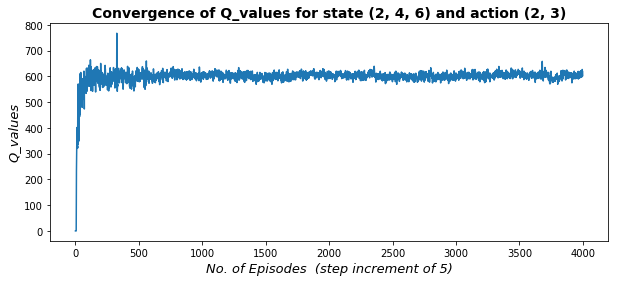

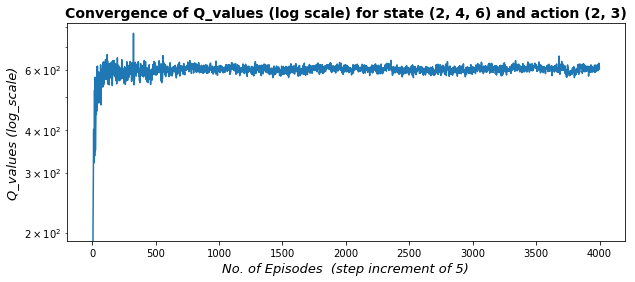




Tracking Convergence for state-action pair 2: State (1,2,3), Action (1,2)



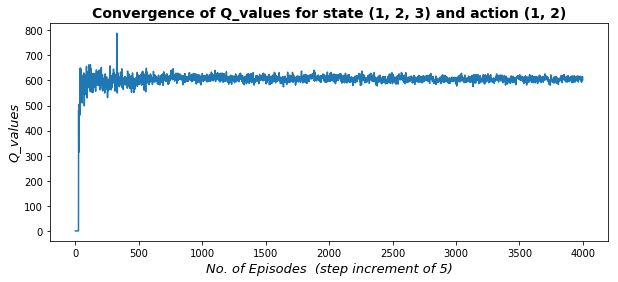

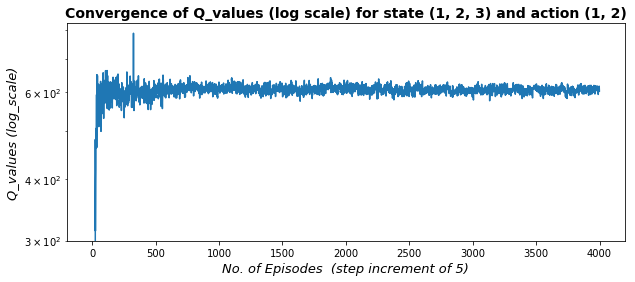

In [24]:
## Convergence Graph 1: For Sample state-action pair 1: State (2,4,6), Action (2,3)
print('\n\033[1m'+"Tracking Convergence for state-action pair 1: State (2,4,6), Action (2,3)\n")
convergence_graph_q_val(fig_num=1, state=(2,4,6), action=(2,3), states_tracked= agent.states_tracked_1)
convergence_graph_q_val_logscale(fig_num=2, state=(2,4,6), action=(2,3), states_tracked= agent.states_tracked_1)

## Convergence Graph 2: For Sample state-action pair 2: State (1,2,3), Action (1,2)
print('\n\n\n\033[1m'+"Tracking Convergence for state-action pair 2: State (1,2,3), Action (1,2)\n")
convergence_graph_q_val(fig_num=3, state=(1,2,3), action=(1,2), states_tracked= agent.states_tracked_2)
convergence_graph_q_val_logscale(fig_num=4, state=(1,2,3), action=(1,2), states_tracked= agent.states_tracked_2)

Thus, from the graphs we can deduce that the sample state-action pairs `'State (2,4,6), Action (2,3)'` and `'State (1,2,3), Action (1,2)'` show convergence over episodes.

#### (ii) Check whether the total rewards earned per episode are showing stability

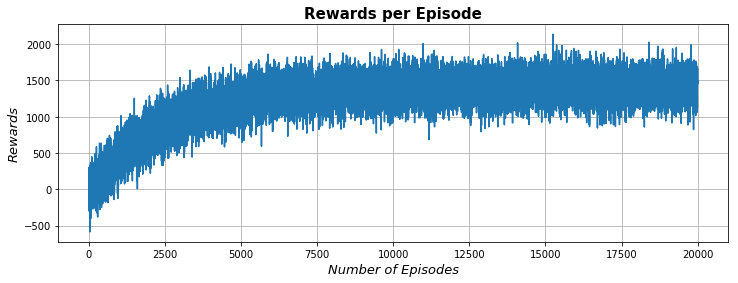

In [25]:
## Rewards (y-axis) vs episodes (x-axis)
plt.figure(5, figsize=(12,4))
plt.title('Rewards per Episode', fontsize=15, fontweight='bold')
xaxis = np.asarray(range(0, len(score_tracked)))
plt.plot(xaxis,np.asarray(score_tracked))
plt.ylabel("Rewards", fontsize=13, fontstyle='italic')
plt.xlabel("Number of Episodes", fontsize=13, fontstyle='italic')
plt.grid(True)
plt.show()

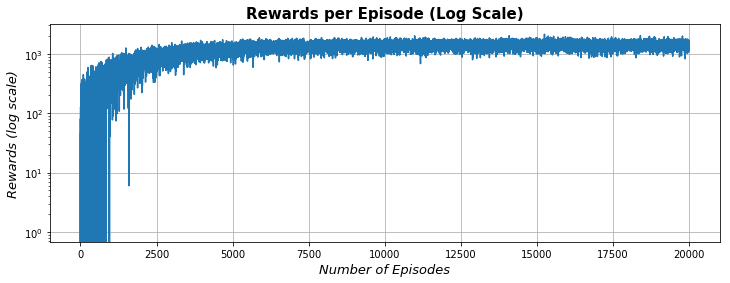

In [26]:
## Rewards (y-axis log scale) vs episodes
plt.figure(6, figsize=(12,4))
plt.title('Rewards per Episode (Log Scale)', fontsize=15, fontweight='bold')
xaxis = np.asarray(range(0, len(score_tracked)))
plt.plot(xaxis,np.asarray(score_tracked))
plt.yscale('log')                                                 ## Log scale: On y-axis
plt.ylabel("Rewards (log scale)", fontsize=13, fontstyle='italic')
plt.xlabel("Number of Episodes", fontsize=13, fontstyle='italic')
plt.grid(True)
plt.show()

From Rewards per Episode (Log scale) graph, we clearly see that the `rewards are quite consistent after 7500 episodes. Thus, showing the model stability.` Hence we can conclude that our model shows decent convergence post 7500 episodes.

### Epsilon-Decay Check 

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

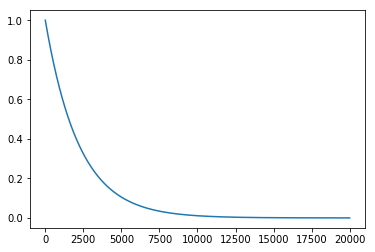

In [27]:
time = np.arange(0,20000)              
epsilon = []
for i in range(0,20000):
    epsilon.append(0.0000001 + (1 - 0.0000001) * np.exp(-0.00045*i))

plt.plot(time, epsilon)
plt.show()